# Mod 4 Project - Time Series Analysis

* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time:
* Instructor name: Ahbineet Kulkarni
* Blog post URL:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import sys
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from numpy import random
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX as SX
from statsmodels.tsa.seasonal import seasonal_decompose as decomp
from statsmodels.tsa.stattools import adfuller
import itertools
register_matplotlib_converters()
from time import time
import math
from fbprophet import Prophet

## Defining Functions

In [2]:
# Function checks if value exists in dataframe or not.
# Mostly used in debugging
def check(df, value):
    for val in value:
        if val in df['ZipCode'].values: 
            print("\nIt exists!")
        else : 
            print("\nDoes not exist!")

In [3]:
# Function that doesn't cut off any columns
# when looking at data
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

## Reading data

In [4]:
zdf = pd.read_csv('zillow_data.csv', low_memory=False)
zdf.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
# After checking a few it seems "RegionName" is actually the zip code
# so I'll go ahead and change that
zdf.rename({'RegionName': 'ZipCode'}, axis='columns', inplace=True)

In [6]:
zdf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 272 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    14723 non-null  int64  
 1   ZipCode     14723 non-null  int64  
 2   City        14723 non-null  object 
 3   State       14723 non-null  object 
 4   Metro       13680 non-null  object 
 5   CountyName  14723 non-null  object 
 6   SizeRank    14723 non-null  int64  
 7   1996-04     13684 non-null  float64
 8   1996-05     13684 non-null  float64
 9   1996-06     13684 non-null  float64
 10  1996-07     13684 non-null  float64
 11  1996-08     13684 non-null  float64
 12  1996-09     13684 non-null  float64
 13  1996-10     13684 non-null  float64
 14  1996-11     13684 non-null  float64
 15  1996-12     13684 non-null  float64
 16  1997-01     13684 non-null  float64
 17  1997-02     13684 non-null  float64
 18  1997-03     13684 non-null  float64
 19  1997-04     13684 non-nu

Something I had suspected, and it seems to be the case: new area codes are added over time so area codes that didn't exist in a particular month have a null value. I can get rid of them without entirely getting rid of the zip code after converting to long format.

The "Metro" column also has null values, presumably because these zip codes are far from any large city. Checking this: Mount Crested Butte, CO is in the middle of nowhere with a population of 801.

Another thing to note is that dates before mid-2014 are in float where dates after are in int, but I believe that will be fixed by converting to datetime.

In [7]:
# Zipcodes in CT, MA, ME, NH, NJ, RI, and VT start with zero
# which is missing in the data set. 
# That bothers me a little so I'm adding it back in.
zdf['ZipCode'] = zdf['ZipCode'].apply('{:0>5}'.format)

## Initial Data Plotting

First I'm going to take a look at modeling the data to make sure everything works properly. Unfortunately, ZipCode 10004 in Lower Manhattan where Flatiron School is located isn't in the dataset, in fact only one Zip Code from Lower Manhattan exists in the data.

In [8]:
check(zdf, ["10002", "10003", "10004", "10005", "10006","10007",
            "10009", "10012", "10013", "10014", "10280", "10282"])


Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

Does not exist!

It exists!

Does not exist!

Does not exist!


I'm going to use the Zip Code I currently live in instead.

In [9]:
Reno = zdf.copy()
Reno = Reno[Reno.ZipCode.isin(["89509"])]

In [10]:
# This function defines a plot using the unmelted data
def Growthplot(df):
    xticks = ['1996-04', '2000-04', '2004-04', '2008-04', '2012-04', '2016-04']
    xlabels = ['1996', '2000', '2004', '2008', '2012', '2016']
    yticks = [100000, 200000, 300000, 400000, 500000, 600000, 700000]
    ylabels = ['100K', '200K', '300K', '400K', '500K', '600K', "700K"]
    plt.figure(figsize=(16,8))
    for n, index in enumerate(df.index):
        sample = df.loc[index,'1996-04':'2018-04']
        zipcode = df.loc[index]['ZipCode']
        plt.plot(sample, label=df.loc[index]['ZipCode'])
    plt.xticks(xticks, labels=xlabels)
    plt.yticks(yticks, labels=ylabels)
    plt.legend()
    plt.title('Zipcode Growth over Period 1996-2018')
    plt.ylabel('Median home price ($)')
    plt.xlabel('Year')
    plt.show();

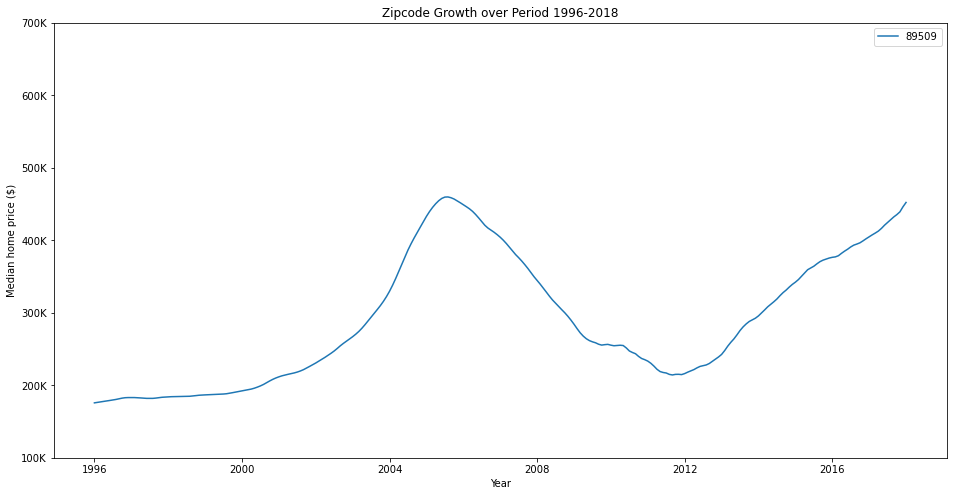

In [11]:
Growthplot(Reno)

This shows the highly variable nature of house prices. It seems that by 2018 in Reno the house prices hadn't gotten back to the level they were at a decade earlier!

This also shows the 2008 housing crisis, but by the looks of things Reno was already starting to lose steam by 2006.

Next I'll try the Denver, Colorado Area.

In [12]:
Denver = zdf.copy()
Denver = Denver[Denver.City.isin(["Denver"])]

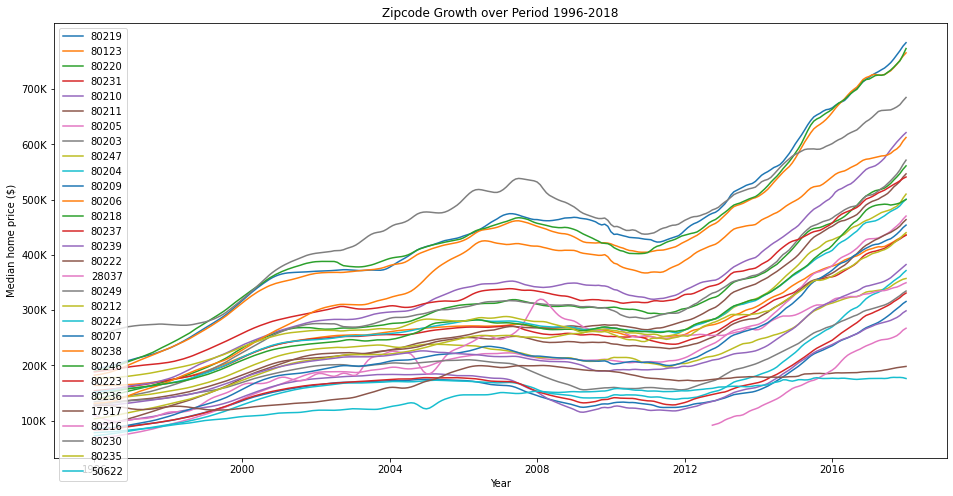

In [13]:
Growthplot(Denver)

The housing bubble is also clear in this graph, and Denver seems to have recovered better than Reno has.

It may be a good idea to eliminate housing prices that are prior to 2012, as the prices were still dropping until then. This way the housing crisis won't factor in, and I can keep more zip codes that didn't exist before then.

In [14]:
mdf = zdf.drop(zdf.loc[:, '1996-04':'2012-03'].columns, axis = 1)

## Melting Data

In [15]:
# Function for transforming data to long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','ZipCode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MedianValue')
    # Converting to datetime
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MedianValue'])
    return melted

In [16]:
# Running function to melt dates
mdf = melt_data(mdf)
mdf.info()
mdf.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070975 entries, 0 to 1074778
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   RegionID     1070975 non-null  int64         
 1   ZipCode      1070975 non-null  object        
 2   City         1070975 non-null  object        
 3   State        1070975 non-null  object        
 4   Metro        995106 non-null   object        
 5   CountyName   1070975 non-null  object        
 6   SizeRank     1070975 non-null  int64         
 7   Month        1070975 non-null  datetime64[ns]
 8   MedianValue  1070975 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 81.7+ MB


(1070975, 9)

Now the dataframe has over a million rows. A good amount of information to look through. I may have to cut down on the number of zips and limit them to a few cities or a state.

I'm not going to use a couple rows so I'll go ahead and delete them now. Also changing MedianValue column into integer values.

In [17]:
mdf.drop(['RegionID', 'SizeRank', 'Metro'], axis=1, inplace=True)
mdf.MedianValue = mdf.MedianValue.apply(lambda x: int(x))
display(mdf.head())

,ZipCode,City,State,CountyName,Month,MedianValue
0,60657,Chicago,IL,Cook,2012-04-01,740300
1,75070,McKinney,TX,Collin,2012-04-01,201800
2,77494,Katy,TX,Harris,2012-04-01,252400
3,60614,Chicago,IL,Cook,2012-04-01,938100
4,79936,El Paso,TX,El Paso,2012-04-01,112800


I'm going to limit the zipcodes to the northwest states of Washington and Oregon. I'm planning on moving to the area in the future, so a future employer would most likely have me dealing with data in the local area.

In [18]:
nws = mdf[(mdf.State.isin(['WA','OR']))].copy()
print(len(nws.ZipCode.unique()))
print(nws.isna().sum())
nws.info()

565
ZipCode        0
City           0
State          0
CountyName     0
Month          0
MedianValue    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41113 entries, 67 to 1074772
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ZipCode      41113 non-null  object        
 1   City         41113 non-null  object        
 2   State        41113 non-null  object        
 3   CountyName   41113 non-null  object        
 4   Month        41113 non-null  datetime64[ns]
 5   MedianValue  41113 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.2+ MB


In [19]:
nws.ZipCode.value_counts()[-10:]

98826    73
97417    73
98115    73
97739    73
98851    64
97733    52
97624    52
97435    46
97499    46
97467    46
Name: ZipCode, dtype: int64

It seems 6 ZipCodes don't have all the values, they were probably added since 2012. Since that is relatively few out of the 565 zips in the two states I'll just delete them.

In [20]:
nws = nws[~nws.ZipCode.isin(["98851", "97733","97624", "97499", "97467", "97435"])]

In [21]:
nws.City.value_counts()

Portland       1898
Seattle        1387
Tacoma          803
Spokane         730
Vancouver       511
               ... 
Canyonville      73
Depoe Bay        73
Oakridge         73
Neskowin         73
Corbett          73
Name: City, Length: 395, dtype: int64

## Visualization

In [22]:
def meltplot(df, title):
    for zipcode in df.ZipCode.unique():
        temp = df[df.ZipCode == zipcode].set_index('Month')
        temp['MedianValue'].plot(figsize=(15,8), label=zipcode)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
    plt.xlabel("Year", fontsize=16)
    plt.ylabel("Median Sale Price (USD)", fontsize=16)
    plt.title(f"Monthly Median Housing Prices in {title}", fontsize=20);

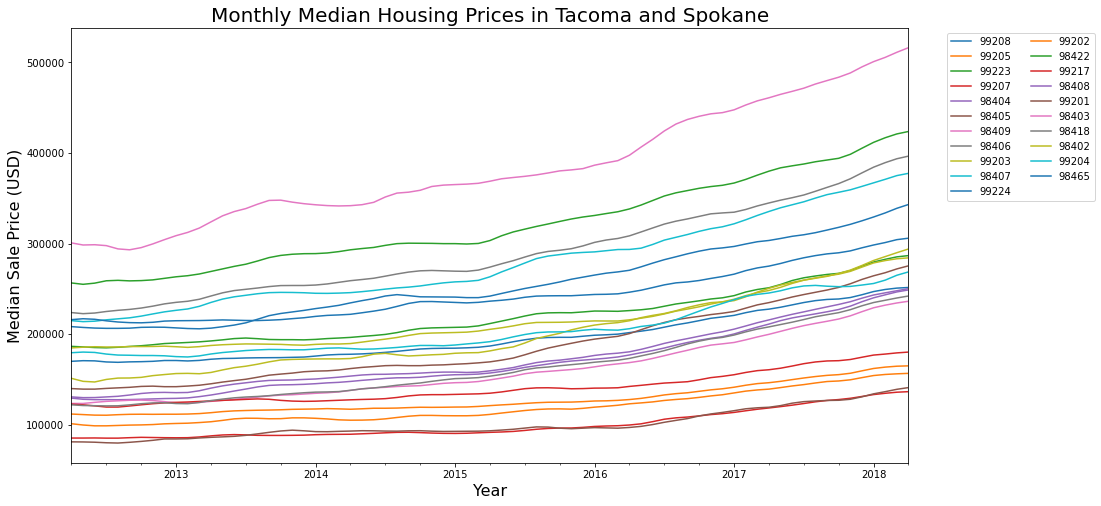

In [23]:
# Plotting data for Tacoma and Spokane
TacSpo = nws[(nws.City.isin(['Tacoma','Spokane']))].copy()
meltplot(TacSpo, "Tacoma and Spokane")

Seems to be working correctly so far. Now I'm going to start modeling the data.

## Modeling

In [24]:
inws = nws.copy()
# Dropping unnecessary columns for modeling
inws = inws.drop(['City', 'State', 'CountyName'], axis=1)
# Setting the month as the index
inws = inws.set_index('Month')

In [25]:
# This function returns dictionaries
# that have been transformed to be useful
# for plotting

def DiTraDi(df):
    
    # Making a dictionary that will contain
    # each zip code as a key with Month and
    # MedianValue as the values
    zips = {}
    logs = {}
    diff = {}
    for zipcode in df.ZipCode.unique():
        x = df[df.ZipCode == zipcode]
        x.drop('ZipCode', axis=1, inplace=True)
        zips[zipcode] = x
        
    # Log transform the values
    for zipcode in zips.keys():
        logs[zipcode] = np.log(zips[zipcode])
        
    # Using the .diff method to find the differences
    # for 12 month periods in the data set which
    # will be useful for seasons
    for zipcode in list(logs.keys()):
        diff[zipcode] = logs[zipcode].diff(periods=12).dropna()
    return diff, logs, zips

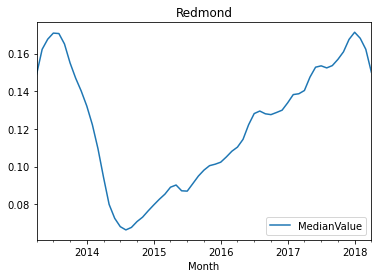

In [26]:
DiTraDi(inws)[0]["98052"].plot(title='Redmond');

It seems to work correctly.

In [27]:
# This function decomposes a dataframe
# to find the seasons, trend, and noise
def decompose(df):
    trend = decomp(df).trend
    seasonal = decomp(df).seasonal
    residual = decomp(df).resid
    # Makes Subplots for each
    plt.figure(figsize=(12,8))
    plt.title(f"Decomposition of {df}")
    plt.subplot(411)
    plt.plot(df, label='Original', color="red")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="lime")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal', color="gold")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();
    return residual.dropna()

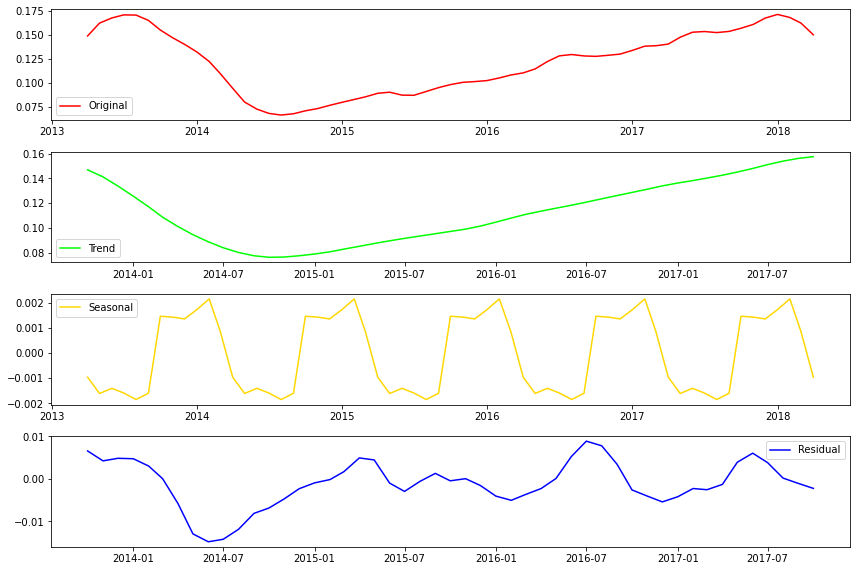

In [28]:
Redmond = decompose(DiTraDi(inws)[0]["98052"])

In [29]:
Redmond = DiTraDi(inws)[1]["98052"]

## Using SARIMAX

Since there is a clear seasonal component we'll use SARIMAX to predict future data. The first thing is to predict the parameters:

In [30]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [31]:
# Here I'm defining a nested function that will put together
# all the parts to make a SARIMAX model
def SRMX(df, pdq):
    # If this isn't put in a whole lot of red shows up
    warnings.filterwarnings('ignore')

# Run a grid with pdq and seasonal pdq parameters calculated above
# to find the best Akaike Information Criterion value
    def findpdq(df, pdq):
        ans = []
        for comb in pdq:
            for combs in pdqs:
                try:
                    mod = SX(df,order=comb,seasonal_order=combs,
                             enforce_stationarity=False,enforce_invertibility=False)

                    output = mod.fit()
                    ans.append([comb, combs, output.aic])
                except:
                    continue
        ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
        result = ans_df.loc[ans_df['aic'].idxmin()]
        return result
    # Running a SARIMAX model
    ARIMA_MODEL = SX(df,order=(findpdq(df, pdq)[0]),
                     seasonal_order=(findpdq(df, pdq)[1]),
                     enforce_stationarity=False, enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    return output

SARIMAX automatically finds the best parameters for the lowest aic score

In [32]:
output = SRMX(Redmond, pdq)

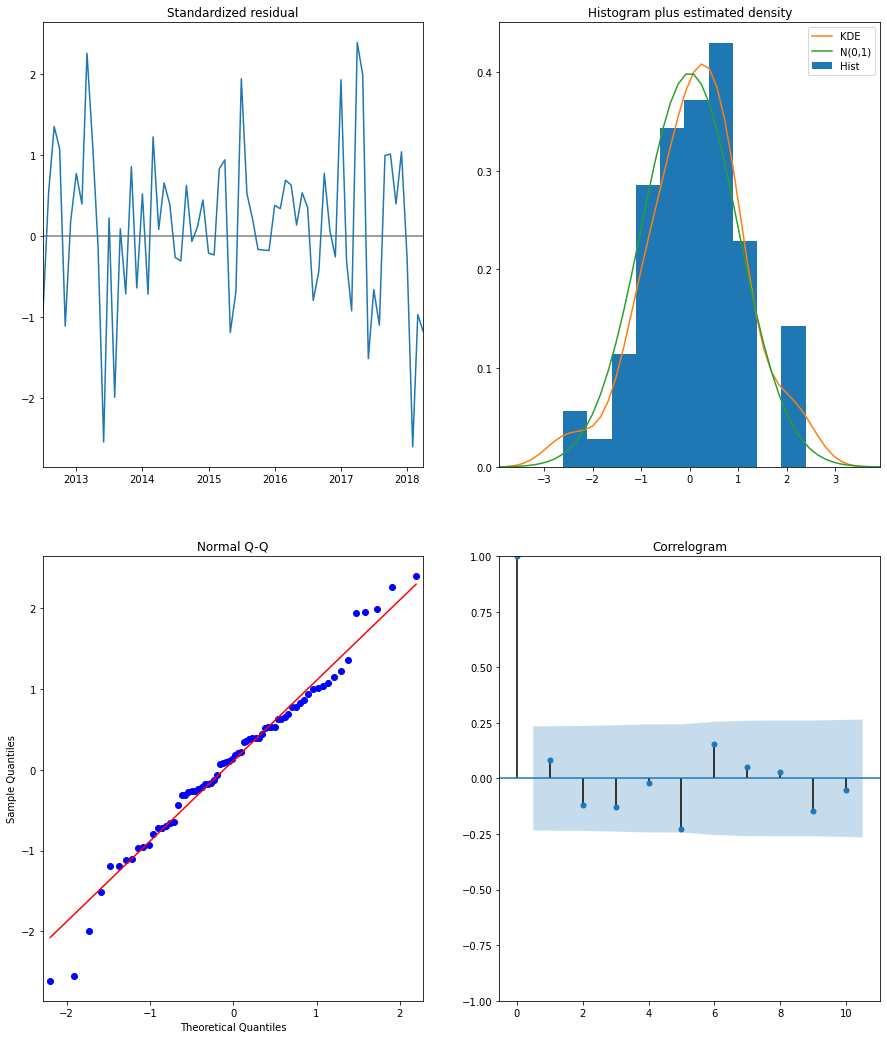

In [33]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The top right histogram is a good indication that the residuals are normally distributed.

The QQ plot follows the line reasonably well, so is another sign the data is normally distributed.

In [34]:
# 2016 seems like a good place to start predicting, with two years to check accuracy
prediction = output.get_prediction(start=pd.to_datetime('2016-09'), dynamic=True)
pred_conf = prediction.conf_int()

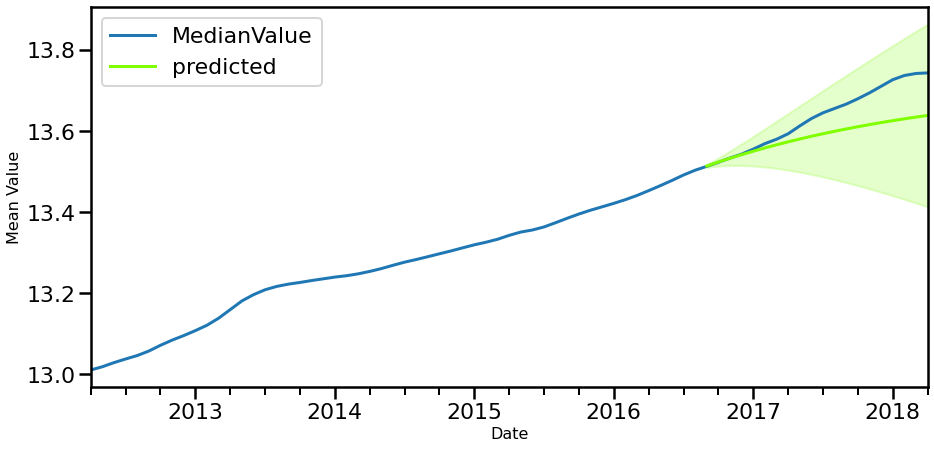

In [35]:
# Plots observed values, predictions, and confidence interval range
sns.set_context('poster')
Redmond['2012':].plot(label='observed')
prediction.predicted_mean.plot(figsize=(15,7),color='chartreuse', label='predicted')
plt.fill_between(pred_conf.index,pred_conf.iloc[:, 0],
                 pred_conf.iloc[:, 1], color='lawngreen', alpha=.2)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mean Value', fontsize=16)
plt.legend()
plt.show()

In [36]:
# Get the Real and predicted values
Redmondtrue = Redmond['2016-09':]
Redmondforecast = prediction.predicted_mean

# Computing the mean square error
rmse = np.sqrt(mean_squared_error(Redmondtrue, Redmondforecast))
print(f'RMSE: {round(rmse, 4)}')

RMSE: 0.0619


So far this is just for Redmond, part of the greater Seattle Area. Now lets add more ZipCodes. First, define functions to make the process easier.

In [37]:
# Returns the ROI for the zipcode from 
def expected_roi(zipcode, startmonth, endmonth):
    growth = zdf.loc[zdf.ZipCode == zipcode][endmonth].values[0] - zdf.loc[zdf.ZipCode == zipcode][startmonth].values[0]
    roi = (growth*100) / zdf.loc[zdf.ZipCode == zipcode][startmonth].values[0]
    return round(roi, 4)

In [38]:
# Testing
expected_roi("89509", "1996-04", "2018-04")

157.281

Investing in houses in Reno since 1998 would have given a 157% ROI. Not amazing for over 20 years, but that's not part of my data set.

In [39]:
# Sorts Northwest states dataframe by Zip, then Month
snws = nws.copy()
snws = snws.sort_values(by=["ZipCode", "Month"]).drop(['City', 'State', 'CountyName'], axis=1)

In [40]:
snws['Month'] = snws.Month.dt.strftime('%Y-%m')

In [41]:
# Getting the first and last months values
firstdf = lastdf = snws.copy()
firstdf = firstdf.iloc[np.arange(0,40807,73)]
lastdf = lastdf.iloc[np.arange(72,40807,73)]

In [42]:
mydict = {}
for x in np.arange(0,559,1):
    new = expected_roi(firstdf.iloc[x][0], firstdf.iloc[x][1], lastdf.iloc[x][1])
    mydict[firstdf.iloc[x][0]] = new

In [43]:
switched = {y:x for x,y in mydict.items()}

In [44]:
sorte = list(sorted(switched.items()))

In [45]:
sorte[-15:]

[(122.41, '98005'),
 (122.4982, '98155'),
 (122.7211, '98146'),
 (123.3647, '98033'),
 (123.9664, '98034'),
 (124.6289, '98004'),
 (125.2881, '97760'),
 (128.6692, '98251'),
 (129.9843, '98118'),
 (130.098, '98144'),
 (130.4032, '98007'),
 (133.3825, '98043'),
 (134.3862, '98168'),
 (140.7987, '98108'),
 (143.3779, '98106')]

In [46]:
bestzips = ["98005","98155","98146","98033","98034","98004","97760","98251",
            "98118","98144","98007","98043","98168","98108","98106"]

## Putting it all Together

In [47]:
def DiTra(df):
    
    # Making a dictionary that will contain
    # each zip code as a key with Month and
    # MedianValue as the values
    zips = {}
    logs = {}
    diff = {}
    for zipcode in df.ZipCode.unique():
        x = df[df.ZipCode == zipcode]
        x.drop('ZipCode', axis=1, inplace=True)
        zips[zipcode] = x
        
    # Log transform the values
    for zipcode in zips.keys():
        logs[zipcode] = np.log(zips[zipcode])
    
        
    return diff, logs

In [60]:
newlist = []
for x in bestzips:
    newlist.append(DiTraDi(inws)[0][x])

Next cell may take a while to run.

In [ ]:
SRMXlist = []
for x in newlist:
    output = SRMX(x, pdq)
    SRMXlist.append(output)

In [ ]:
predlist = []
for x in SRMXlist:
    prediction = x.get_prediction(start=pd.to_datetime('2016-09'), dynamic=True)
    pred_conf = prediction.conf_int()
    predlist.append(pred_conf)

In [ ]:
def plotsrmx(list):
    for x in list:
        x['2012':].plot(label='observed')
        prediction.predicted_mean.plot(figsize=(15,7),color='chartreuse', label='predicted')
        plt.fill_between(pred_conf.index,pred_conf.iloc[:, 0],
                         pred_conf.iloc[:, 1], color='lawngreen', alpha=.2)
        plt.xlabel('Date', fontsize=16)
        plt.ylabel('Mean Value', fontsize=16)
        plt.legend()
        plt.show()
        xtrue = x['2016-09':]
        xforecast = prediction.predicted_mean
        rmse = np.sqrt(mean_squared_error(xtrue, xforecast))
        print(f'RMSE: {round(rmse, 4)}')

In [ ]:
# Plotting all the zipcodes
plotsrmx(predlist)